# PROJECT 2: DECISION TREE
Môn học: Artificial Intelligence

## Khai báo thư viện

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Chuẩn bị tập dữ liệu

### Tải tập dữ liệu

In [41]:
# Breast Cancer Dataset
from sklearn.datasets import load_breast_cancer 
breast_cancer_wisconsin_diagnostic = load_breast_cancer()
bc_features = pd.DataFrame(breast_cancer_wisconsin_diagnostic.data, columns=breast_cancer_wisconsin_diagnostic.feature_names)  # Các đặc trưng
bc_labels = pd.Series(breast_cancer_wisconsin_diagnostic.target, name="label")  # Nhãn: 0 = Malignant, 1 = Benign

# Wine Quality Dataset
file_path = './wine+quality/winequality-white.csv'
wine_data = pd.read_csv(file_path, sep=';')
wine_features = wine_data.iloc[:, :-1]
wine_labels = wine_data['quality']

### Chuẩn bị các tập dữ liệu

In [42]:
def prepare_datasets(features, labels):
    subsets = []
    subsets.append(train_test_split(features, labels, train_size=0.4, stratify=labels, shuffle=True, random_state=0))
    subsets.append(train_test_split(features, labels, train_size=0.6, stratify=labels, shuffle=True, random_state=0))
    subsets.append(train_test_split(features, labels, train_size = 0.8, stratify = labels, shuffle = True, random_state = 0)) # The 80/20 set
    subsets.append(train_test_split(features, labels, train_size = 0.9, stratify = labels, shuffle = True, random_state = 0)) # The 90/10 set

    return subsets


# Tạo các tập huấn luyện và kiểm tra cho Breast Cancer Dataset
bc_datasets = prepare_datasets(bc_features, bc_labels)

# Tạo các tập huấn luyện và kiểm tra cho Wine Quality Dataset
wine_datasets = prepare_datasets(wine_features, wine_labels)


In [43]:
from sklearn.model_selection import train_test_split

# Hàm chuẩn bị dữ liệu
def prepare_datasets(features, labels):
    subsets = {}  # Sử dụng dictionary thay vì danh sách để dễ dàng lưu trữ các tập
    # Chia dữ liệu với các tỷ lệ khác nhau và lưu vào dictionary
    feature_train_40, feature_test_60, label_train_40, label_test_60 = train_test_split(features, labels, train_size=0.4, stratify=labels, shuffle=True, random_state=0)
    subsets['train_40'] = (feature_train_40, label_train_40)
    subsets['test_60'] = (feature_test_60, label_test_60)

    feature_train_60, feature_test_40, label_train_60, label_test_40 = train_test_split(features, labels, train_size=0.6, stratify=labels, shuffle=True, random_state=0)
    subsets['train_60'] = (feature_train_60, label_train_60)
    subsets['test_40'] = (feature_test_40, label_test_40)

    feature_train_80, feature_test_20, label_train_80, label_test_20 = train_test_split(features, labels, train_size=0.8, stratify=labels, shuffle=True, random_state=0)
    subsets['train_80'] = (feature_train_80, label_train_80)
    subsets['test_20'] = (feature_test_20, label_test_20)

    feature_train_90, feature_test_10, label_train_90, label_test_10 = train_test_split(features, labels, train_size=0.9, stratify=labels, shuffle=True, random_state=0)
    subsets['train_90'] = (feature_train_90, label_train_90)
    subsets['test_10'] = (feature_test_10, label_test_10)

    return subsets

# Tạo các tập huấn luyện và kiểm tra cho Breast Cancer Dataset
bc_datasets = prepare_datasets(bc_features, bc_labels)

# Tạo các tập huấn luyện và kiểm tra cho Wine Quality Dataset
wine_datasets = prepare_datasets(wine_features, wine_labels)

# Kiểm tra kết quả
print("Breast Cancer Datasets Keys:", list(bc_datasets.keys()))
print("Wine Quality Datasets Keys:", list(wine_datasets.keys()))


Breast Cancer Datasets Keys: ['train_40', 'test_60', 'train_60', 'test_40', 'train_80', 'test_20', 'train_90', 'test_10']
Wine Quality Datasets Keys: ['train_40', 'test_60', 'train_60', 'test_40', 'train_80', 'test_20', 'train_90', 'test_10']


In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Danh sách tên các lớp
class_names_bc = ["Malignant", "Benign"]  # Breast Cancer: 0 = Malignant, 1 = Benign
class_names_wine = [str(i) for i in range(11)]  # Wine Quality: chất lượng từ 0 đến 10

def draw_plot(original, train, test, title, class_names, ax):
    # Tính tần suất các lớp, đảm bảo rằng tất cả các lớp đều được hiển thị
    count_org = pd.Series(original).value_counts().reindex(range(len(class_names)), fill_value=0)
    count_train = pd.Series(train).value_counts().reindex(range(len(class_names)), fill_value=0)
    count_test = pd.Series(test).value_counts().reindex(range(len(class_names)), fill_value=0)

    # Tạo DataFrame để lưu phân phối lớp
    frame = pd.DataFrame({'original': count_org, 'train': count_train, 'test': count_test})

    # Vẽ biểu đồ cột
    frame.plot(kind='bar', ax=ax, xlabel="Classes", ylabel="Count", title=title, color=['#f45d01', '#eeb902', '#97cc04'])
    ax.bar_label(ax.containers[0])  # Thêm nhãn cho cột
    ax.set_xticklabels(class_names, rotation=0)  # Đặt nhãn cho trục x


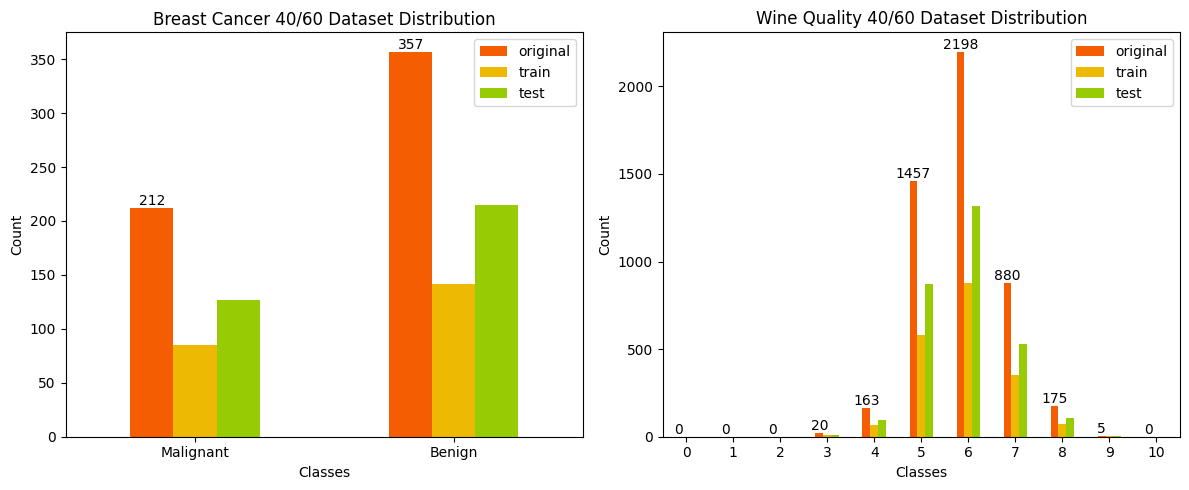

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 hàng, 2 cột

draw_plot(bc_labels, bc_datasets['train_40'][1], bc_datasets['test_60'][1], "Breast Cancer 40/60 Dataset Distribution", class_names_bc, axs[0])
draw_plot(wine_labels, wine_datasets['train_40'][1], wine_datasets['test_60'][1], "Wine Quality 40/60 Dataset Distribution", class_names_wine, axs[1])

plt.tight_layout()
plt.show()

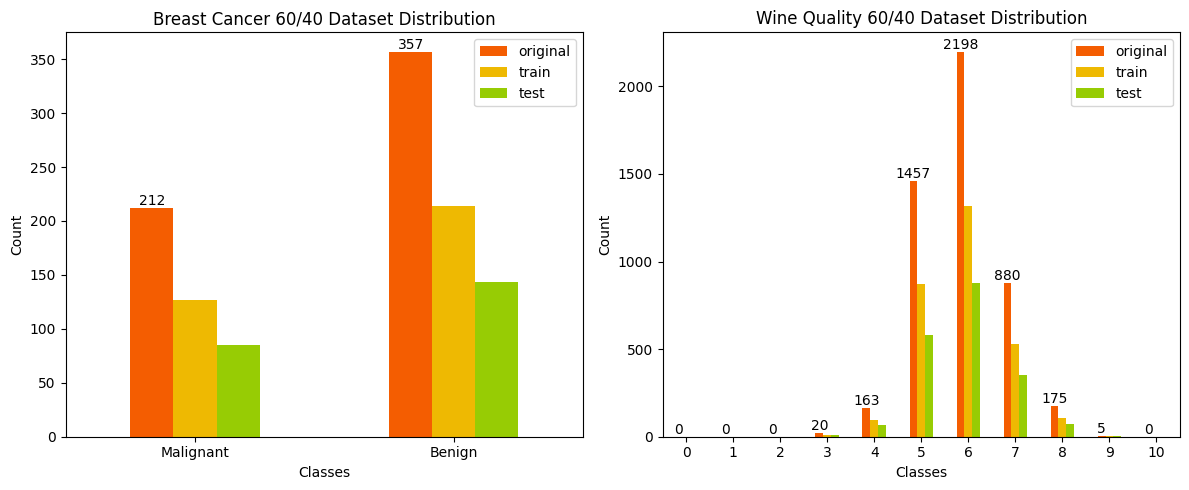

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

draw_plot(bc_labels, bc_datasets['train_60'][1], bc_datasets['test_40'][1], "Breast Cancer 60/40 Dataset Distribution", class_names_bc, axs[0])
draw_plot(wine_labels, wine_datasets['train_60'][1], wine_datasets['test_40'][1], "Wine Quality 60/40 Dataset Distribution", class_names_wine, axs[1])

plt.tight_layout()
plt.show()

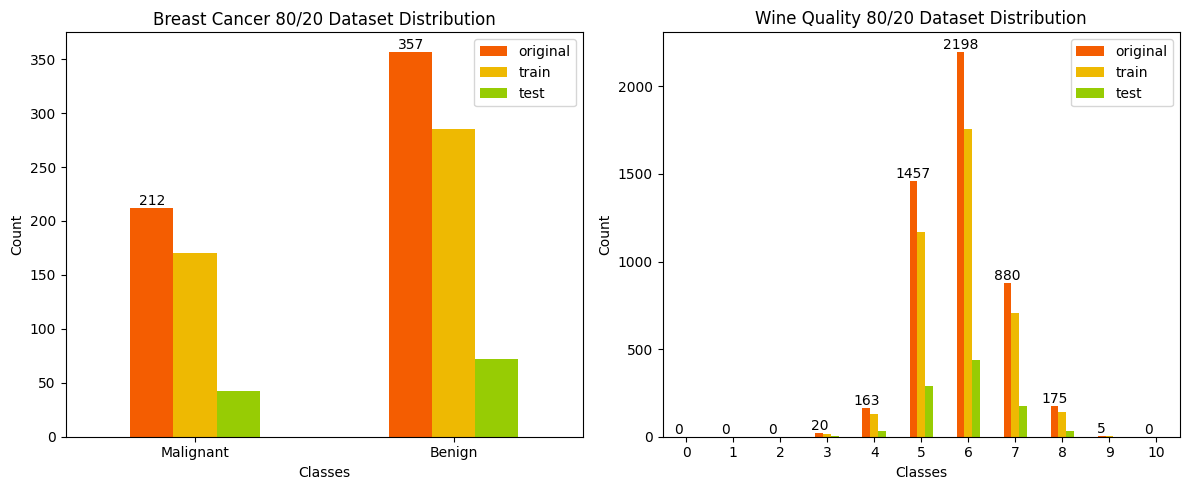

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

draw_plot(bc_labels, bc_datasets['train_80'][1], bc_datasets['test_20'][1], "Breast Cancer 80/20 Dataset Distribution", class_names_bc, axs[0])
draw_plot(wine_labels, wine_datasets['train_80'][1], wine_datasets['test_20'][1], "Wine Quality 80/20 Dataset Distribution", class_names_wine, axs[1])

plt.tight_layout()
plt.show()

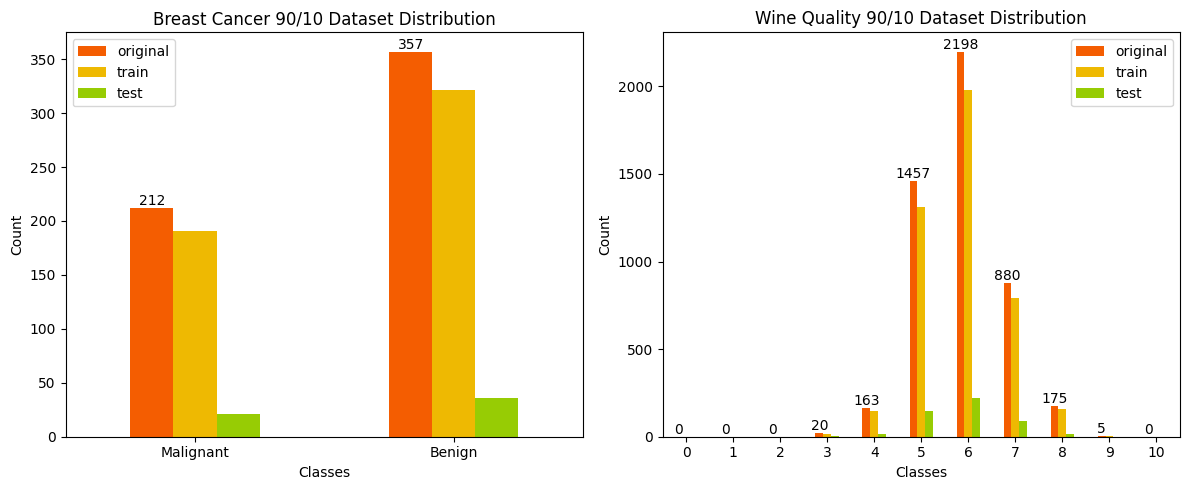

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

draw_plot(bc_labels, bc_datasets['train_90'][1], bc_datasets['test_10'][1], "Breast Cancer 90/10 Dataset Distribution", class_names_bc, axs[0])
draw_plot(wine_labels, wine_datasets['train_90'][1], wine_datasets['test_10'][1], "Wine Quality 90/10 Dataset Distribution", class_names_wine, axs[1])

plt.tight_layout()
plt.show()